### Overview of Prognostic Types

In this notebook, we will examine three different types of prognostic models:

* Type 1: Population-Based
* Type 2: Environment-Based
* Type 3: Component-Based

The goal of each model is the prediction of Remaining Useful Life (RUL):

[IMAGE IN BLOG POST]

Type 1 prognostic models consider component failures within a population of similar components. By collecting historical failure data from a large number of components, the expected failure time of a “typical” component can be determined by finding the mean-time-to-failure of the failure distribution. Assuming that new components exhibit typical behavior, the expected RUL is the time until the mean-time-to-failure of the distribution. Traditional reliability engineering techniques develop Type 1 prognostic models, usually assuming that component failures follow either an exponential or Weibull distribution. Type 1 models are inexpensive to construct, but they may be less accurate than Type 2 and Type 3 models. Reliability databases, including the OREDA Offshore Reliability Handbook, Nonelectric Parts Reliability Database, and the European Industry Reliability Data Bank can be consulted to find enough relevant failure data to construct a Type 1 model.

[IMAGE IN BLOG POST]

Type 2 prognostic models take into account the environmental factors which may increase or decrease the typical failure time of the component, such as ambient temperature or operational load. Grouping components together into subpopulations based on operating factors will result in a more accurate RUL prediction. For example, batteries operated in cold environments will generally lose their charge faster than those operated in warm environments; if the environment of a particular battery is known beforehand, the typical failure time can be adjusted accordingly. In many cases, the environmental factors are already known or the information can be gathered without much trouble. To construct a Type 2 model, expert knowledge may assign components to appropriate subpopulations, or machine learning algorithms can detect these subpopulations automatically.

[IMAGE IN BLOG POST]

Type 3 prognostic models (also known as a “condition-monitoring” approach) determine the accumulated degradation at the component-level. By associating measurable signals with the degradation of a particular component, the increase in degradation over time can be trended towards functional failure. This process requires that monitoring devices/sensors are placed on all components. As such, Type 3 models are more expensive to implement than the other two types; however, assuming they are constructed correctly, Type 3 models usually provide the most accurate prediction of RUL. In many cases, enough sensors are already installed on the component to perform Type 3 prognostics, and additional expense is unnecessary. In conjunction with historical failure data, machine learning algorithms facilitate Type 3 model construction by discovering the signals/features most strongly correlated with degradation.

[IMAGE IN BLOG POST]

Determining which type of prognostic model to select for a given situation is a judgment call. A Type 1 prognostics model might be the most resource-efficient choice for highly redundant, inexpensive, or replaceable components. However, components which are safety-critical or expensive might require Type 3 prognostics to ensure that imminent failure is detected with enough time to schedule maintenance. Assuming that safety and mission factors are not important, the cost of a prognostic approach should not exceed the cost of replacement plus downtime/business interruption costs.

The code from Part 2 is reproduced below, without comments. Please refer to Part 2 of this notebook series for more information.

In [1]:
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# Please adjust the random seed for new results
np.random.seed(11)

# See Part 2 for code comments
def core_hot_spot(ambient_temp, overload_ratio, t0=35, tc=30, N=1, 
                N0=0.5, Nc=0.8, L=1):
    T = t0*((N*overload_ratio**2+1)**0.8) + tc*L*overload_ratio**2 + ambient_temp
    return T

def calculate_dp(core_hot_spot, time, dp_initial):
    A = 3.65*10**7
    k = A*np.exp(-(117000/(8.314*(core_hot_spot+273.15))))
    DPf=1/((k*24*7*time) + (1/dp_initial))
    return DPf

def oil_contamination(dp):
    CO=(-0.0028*dp + 6.28) + 0.13*np.random.randn()
    CO2=(-0.0026*dp + 8.08) + 0.66*np.random.randn()
    return CO, CO2

def tinsul_sim(temps, start_month, num_transformers, overload_ratio = 1):
    trans_co = []
    trans_co2 = []
    for ii in range(num_transformers):
        month_current = start_month 
        failed = False
        dp_current = 1000
        co_accumulation = []
        co2_accumulation = []
        dp_failed = np.random.logistic(loc=200.0, scale=40.0)
        while not failed:   
            ambient_low = [temps[int(month_current)-1][0], 6]
            ambient_avg = [temps[int(month_current)-1][1], 12]
            ambient_high = [temps[int(month_current)-1][2], 6]     
            for ambient, time in [ambient_low, ambient_avg, ambient_high]:
                chs = core_hot_spot(ambient, overload_ratio)
                dp_current = calculate_dp(chs, time, dp_current)
            co, co2 = oil_contamination(dp_current)
            co_accumulation.append(co)
            co2_accumulation.append(co2)
            if (dp_current<=dp_failed) | (dp_current<=150):
                failed = True
            month_current += 0.230769
            if month_current >= 13.0:
                month_current = 1
        trans_co.append(co_accumulation)
        trans_co2.append(co2_accumulation)
    return trans_co, trans_co2     

### Type I Prognostics: Population-Based

As a practical example, let’s consider these three prognostic approaches in terms of transformer condition-monitoring. Karen is a data scientist constructing a prognostics model for paper insulation failure in step-up transformers. She might begin her analysis by gathering historical failure data from several locations across America. Remember that Type I prognostic models examine the failure distribution of a population of similar components to establish the typical component lifetime.

Using the transformer simulator, failure data from a total of 750 transformers was generated. Assumptions include: the transformers operated at a constant overload ratio of 1, the simulation was begun in January, the paper insulation had no degradation at the start of the simulation, and all transformers had a run-to-failure maintenance strategy. All other assumptions made during Part 2 hold, as well. 

As is common practice during model construction, the data was separated into training and testing datasets. The model will be built using the training dataset, and performance will be evaluated using the testing dataset. Following this procedure reduces the effects of over-generalization when evaluating model performance, which otherwise might be strongly affected by eccentricities of the training data.

In [2]:
# Washington DC
dc_temps = [[-2, 1, 6], [-1, 3, 8], [3, 7, 13], [8, 13, 19], [14, 18, 24], [19, 24, 29], [22, 28, 31], [21, 27, 30], [17, 22, 26], [10, 15, 20], [5, 10, 14], [0, 4, 8]]
# Phoenix AZ
ph_temps = [[8, 14, 20], [9, 16, 22], [12, 18, 25], [16, 23, 30], [21, 27, 35], [25, 32, 40], [29, 34, 42], [28, 32, 40], [25, 31, 38], [18, 24, 32], [12, 18, 24], [7, 12, 18]] 
# Denver CO
de_temps = [[-8, -1, 7], [-7, 0 ,7], [-3, 3, 12], [1, 7, 16], [7, 14, 21], [12, 20, 27], [15, 22, 31], [14, 20, 30], [9, 15, 25], [2, 10, 18], [-4, 4, 12], [-9, -1, 6]] 

# Training data
dc_train = tinsul_sim(dc_temps, 1, 200) 
ph_train = tinsul_sim(ph_temps, 1, 200) 
de_train = tinsul_sim(de_temps, 1, 200) 
# Testing data
dc_test = tinsul_sim(dc_temps, 1, 50) 
ph_test = tinsul_sim(ph_temps, 1, 50) 
de_test = tinsul_sim(de_temps, 1, 50) 

# Failure times of the training data, for model construction
fails_dc_train = [len(dg) for dg in dc_train[0]]
fails_ph_train = [len(dg) for dg in ph_train[0]]
fails_de_train = [len(dg) for dg in de_train[0]]
# Failure times of the testing data, for model evaluation
fails_dc_test = [len(dg) for dg in dc_test[0]]
fails_ph_test = [len(dg) for dg in ph_test[0]]
fails_de_test = [len(dg) for dg in de_test[0]]

# For the Type 1 model, we don't consider each of the 3 areas separately,
# so we will lump all the data together in the same array
type1_fails_train = [*fails_dc_train, *fails_ph_train, *fails_de_train]

The resulting failure distribution of all simulated transformers from the training set is shown below. The predicted mean-time-to-failure and Weibull parameters are given in the title of the figure.

*Note- The mean-time-to-failure is not the only way to calculate the Remaining Useful Life (RUL) for Type 1 and Type 2 models. For safety-critical components, more stringent criteria (such as 5th percentile of the distribution) might be chosen. As the failure data was fitted to a Weibull distribution, the Xth percentile of this Weibull distribution may be found and used as the RUL instead. However, since our goal in this notebook is to determine the relative accuracy of each type of prognostics using the same dataset, treating the mean-time-to-failure as the RUL will provide the best comparison.*

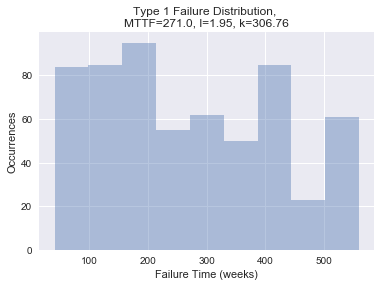

In [3]:
# Calculate metrics
fd = np.array(type1_fails_train)
mttf = fd.mean()
res = stats.weibull_min.fit(fd, floc=0)

# Plot the results from above
sns.distplot(fd, kde=False)
plt.title('Type 1 Failure Distribution, \nMTTF={}, l={}, k={}'.format(str(round(mttf,2)), str(round(res[0],2)), str(round(res[2],2))))
plt.xlabel('Failure Time (weeks)')
plt.ylabel('Occurrences');

Looking at the shape of the distribution, Karen wonders if the accuracy of this Type 1 model is sufficient- the distribution is spread widely between 50 and 550. She calculates the mean absolute error of this approach as follows:

In [4]:
# Remember that we divided the data into training and testing sets
# This section (model evaluation) needs to use the testing set
type1_fails_test = [*fails_dc_test, *fails_ph_test, *fails_de_test]
ae_arr = [np.abs(ii - mttf) for ii in type1_fails_test]
type1_mae = np.mean(ae_arr)
print('Type 1 MAE is {} weeks'.format(str(round(type1_mae,2))))

Type 1 MAE is 122.08 weeks


Examining the results, the mean absolute error is too large to be useful. Karen crunches the numbers, and predicting a transformer failure with an accuracy of about two years is not good enough to reduce maintenance costs. On average, maintenance will be performed much earlier or later than required. She needs to find a more accurate model.

### Type 2 Prognostics: Environment-Based

Next, Karen digs deeper into the research literature and notices the environmental factors mentioned during Part 2 of this notebook series, discovering that the ambient temperature of the transformer affects the failure time of the paper insulation. Hence, it is not fair to compare transformers from Phoenix, AZ to those in Denver, CO. As you might recall, Type 2 prognostics divides the entire failure population into subpopulations, according to operational and environmental factors. Building her own Type 2 model, Karen reassigns the transformers to three separate sub-populations, based on the environmental factors they are exposed to.

The same simulated data from the "Type 1 Prognostics" section was used. However, this time, the failure distribution of each city was calculated independently. Assuming that the location of each testing transformer is known (usually a good assumption), assigning it to the correct subpopulation will increase model accuracy.

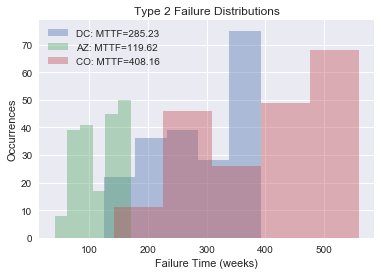

In [5]:
# Find the MTTF for each distribution
mttf_dc = np.array(fails_dc_train).mean()
mttf_ph = np.array(fails_ph_train).mean()
mttf_de = np.array(fails_de_train).mean()
# Plot the failure distribution of all three areas of the country
# on top of each other
sns.distplot(fails_dc_train, kde=False)
sns.distplot(fails_ph_train, kde=False)
sns.distplot(fails_de_train, kde=False)
plt.title('Type 2 Failure Distributions')
plt.xlabel('Failure Time (weeks)')
plt.legend(['DC: MTTF={}'.format(str(round(mttf_dc, 2))), 
           'AZ: MTTF={}'.format(str(round(mttf_ph, 2))), 
           'CO: MTTF={}'.format(str(round(mttf_de, 2)))])
plt.ylabel('Occurrences');

Notice, of course, that transformers in AZ will usually fail first (hot ambient temperature), while many transformers in CO (cold ambient temperature) may survive up to five times longer. Compare the MTTF of each of the three distributions (in the legend), which varies greatly.

As before, Karen calculates the mean absolute error of the Type 2 model, to compare its accuracy to the Type 1 model from the previous section:

In [6]:
# Remember that we divided the data into training and testing sets
# This section (model evaluation) needs to use the testing set
ae_arr2 = []
for env_dist, env_mttf in zip([fails_dc_test, fails_ph_test, fails_de_test], 
                           [mttf_dc, mttf_ph, mttf_de]):
    ae = [np.abs(ii - env_mttf) for ii in env_dist]
    ae_arr2.extend(ae)
type2_mae = np.mean(ae_arr2)
print('Type 2 MAE is {} weeks'.format(str(round(type2_mae,2))))

Type 2 MAE is 72.0 weeks


Simply knowing which environment the transformer has been exposed to will significantly improve the accuracy of the model by about half a year.

### Type 3 Prognostics: Equipment-Based

Finally, Karen has an epiphany- if the ambient temperature each individual transformer experiences over its lifetime can be estimated, why not take this approach a step further and make RUL predictions for each transformer? After all, the transformers that she’s examining have Dissolved Gas Analysis (DGA) devices installed. Since her research indicated that dissolved gases are well-correlated with paper insulation degradation, she can create a Type 3 prognostics model by trending the carbon monoxide and carbon dioxide measurements towards a functional failure.

To establish the measurement threshold at which the paper insulation is likely to fail, Karen finds the sum of the CO and CO2 accumulation *at failure* (i.e. the last available data point for each transformer in the training set) for all transformers in the training dataset:

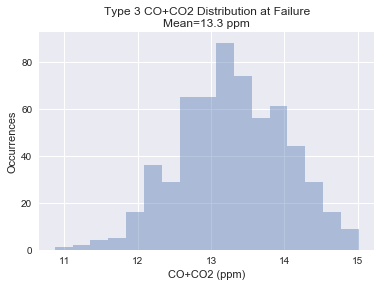

In [7]:
# Determine the CO + CO2 accumulation at failure by finding
# the last value in each array
co_co2_accum = []
for co, co2 in [dc_train, ph_train, de_train]:
    for co_per_trans, co2_per_trans in zip(co, co2):
        co_co2_accum.append(co_per_trans[-1] + co2_per_trans[-1])
type3_mean = np.array(co_co2_accum).mean()

# Plot the results
sns.distplot(co_co2_accum, kde=False)
plt.title('Type 3 CO+CO2 Distribution at Failure\nMean={} ppm'.format(
         str(round(type3_mean,2))))
plt.xlabel('CO+CO2 (ppm)')
plt.ylabel('Occurrences');

The distribution of CO+CO2 accumulation at failure looks fairly Gaussian. Examine the transformer simulation from Part 2 of this notebook series to determine why this might be the case.

Using 13.3 ppm as a "hard" failure threshold, the CO+CO2 measurements from the testing transformers can be trended using a regression model to find the remaining time until the 13.3 ppm threshold is reached (e.g. the "Remaining Useful Life"). From her research, Karen determines that a log regression model is the best functional fit. The full data from all training transformers is used to create an "expected" functional fit, under the assumption that the testing transformers will behave similarly:

In [8]:
# The param_1 and param_2 arrays will contain the 
# functional fit for each individual transformer
param_1 = []
param_2 = []
for co, co2 in [dc_train, ph_train, de_train]:
    for co_per_trans, co2_per_trans in zip(co, co2):
        # t is in weeks; max t is the length of the array
        t = np.linspace(0, 1, len(co_per_trans))
        co_co2 = np.add(co_per_trans, co2_per_trans)
        # fit using a log function
        fit_t = np.polyfit(t, np.log(co_co2), 1)
        # Save the two model parameters calculated above 
        # in the param_1 and param_2 arrays
        param_1.append(fit_t[0])
        param_2.append(fit_t[1])

# Find the "typical" log model parameters by taking the mean
# of each param array
type3_param1 = np.mean(param_1)
type3_param2 = np.mean(param_2)
print('Type 3 functional fit is [{}, {}]'.format(
      str(round(type3_param1,2)), str(round(type3_param2,2))))

Type 3 functional fit is [0.31, 2.33]


The first parameter above is the slope of the log model, and the second parameter is the intercept. Why did Karen find the average of the log model parameters from the training dataset instead of simply regressing the data from the testing transformers directly? There might be some unacceptable variation in the testing transformers, especially if very little data has been accumulated (such as when the transformer is in the early stages of its lifetime). For example, what if there is a negative slope during the initial data of a testing transformer? By projecting future DGA values using the "typical" fit established by the training data, the accuracy (and "safety") of the model is increased.

Of course, using the full CO+CO2 accumulation of the testing transformers seems like cheating- if Karen already knew the full accumulation, she would also know the transformer's exact failure time, which would trivially solve the problem. To make the situation more fair, Karen will make a prediction at a random time in each testing transformer's lifetime (starting at its middle-of-life), and predicting the failure time accordingly:

In [9]:
# ae_arr3 will contain the absolute error from each transformer
ae_arr3 = []
# Iterate over all transformers from the testing data set
for co, co2 in [dc_test, ph_test, de_test]:
    for co_per_trans, co2_per_trans in zip(co, co2):
        fail_time = len(co_per_trans)
        # 1. Clip the array at a random time in the transformer lifetime
        np.random.seed(11)
        end_time = np.random.randint(int(fail_time/2), fail_time-1) 
        #end_time = np.random.randint(1, fail_time-1)   
        co_per_trans = co_per_trans[0:end_time]
        co2_per_trans = co2_per_trans[0:end_time]
        # 2. Find the functional fit of the testing data
        # t is in weeks; max t is the length of the array
        t = np.linspace(0, 1, end_time)
        co_co2 = np.add(co_per_trans, co2_per_trans)
        # fit using a log function
        fit_t = np.polyfit(t, np.log(co_co2), 1)
        # find the predicted co+co2 at the last data point
        # why do this? to smooth out the noise in the "actual"
        # last data point
        cur_co_co2 = fit_t[0]*end_time + fit_t[1]
        # 3. Find the predicted remaining useful life
        # now, determine where the future co+co2 values will
        # reach the failure threshold determined above
        t = 0 # time until predicted failure
        while cur_co_co2<= type3_mean:
            t += 1
            cur_co_co2 += type3_param1
        # 4. Find the prediction error
        actual_rul = fail_time - end_time
        ae = np.abs(t-actual_rul)
        ae_arr3.append(ae)
type3_mae = np.mean(ae_arr3)
print('Type 3 MAE is {} weeks'.format(str(round(type3_mae,2))))

Type 3 MAE is 52.35 weeks


Reading over the above code might seem a little confusing, so let's examine it in more detail. For each testing transformer, the following steps are accomplished:

1. **Clip the array at a random time in the transformer lifetime.** For testing purposes only. The entire CO+CO2 history of each transformer is not known, but at least half of the lifetime is available. In practice, this prognostic algorithm will be run on transformer data where the actual failure time is not known.
2. **Find the functional fit of the testing data.** During this step, the *testing data* of a transformer is fitted to a log regression function. Then, at the last available data point (this index was found during the first step), the *current* CO+CO2 accumulation is estimated. This step might seem unnecessary; why wouldn't we simply use the "true" value at the last time step? However, there is random noise in the data due to measurement/model error, and using the functional fit will decrease the noise somewhat.
3. **Find the predicted remaining useful life.** Using the value at the last known time step (calculated during Step 2), the typical equipment functional fit is extended to determine *when* the CO+CO2 will cross the failure threshold. To accomplish this, the slope of the typical functional fit was added to the current CO+CO2 accumulation at each future time step. Whenever the current value crossed the failure threshold, the *while* loop was terminated. (Other solutions to this problem are available; this one may be dangerous if the typical functional fit might have a negative slope, but in practice that situation is rare)
4. **Find the prediction error.** The *actual* remaining useful life is the duration between the end of the array (*fail_time*) and the place where the array was randomly clipped (*end_time*). During this final step, the error between *predicted* remaining useful life (from the previous step) and the *actual* remaining useful life is determined.

In summary, the mean absolute error (MAE) of the three models are as follows:

* Type 1: 122.08 weeks
* Type 2: 72.0 weeks
* Type 3: 52.35 weeks

As can be seen, the Type 3 model achieves the best MAE. However, Type 3 model accuracy depends entirely on *when* the prediction is made, being greater near the end-of-life than the beginning-of-life. This can be clearly seen by adjusting the "end time" in the code above so that the random array "clipping" begins at 1, instead of the middle-of-life. 

Consider also the cost of installing those DGA devices for the Type 3 models. Was the cost worth it to achieve a MAE increase of 20 weeks? Of course, this notebook was a simulation with many simplifying assumptions. In practice, Type 3 prognostic models often increase the MAE by a much greater margin.

Bonus question- how might Karen improve the accuracy of her Type 3 model even further? (*hint- think about how the Type 2 and Type 3 approaches might be combined into a single model).*